In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh, CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch import optim

from torch.distributions.multivariate_normal import MultivariateNormal

from torchinfo import summary

from models import U_Net

from RectifiedFlow import RectifiedFlow_Unet, train_rectified_flow_Unet

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 128   #len: 5918
num_samples_train = 5000

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
input_shape = (batch_size, 2, 32, 32)

In [5]:
v_model_1 = U_Net(input_shape=input_shape, output_channels=1, initial_lr=5e-3, momentum=0.9, weight_decay=0.0)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [6]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)
# optim.beta1 = 0.9
# optim.eps = 1e-8
#optimizer_1 = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3, momentum=0.99)
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

In [7]:
rectified_flow = train_rectified_flow_Unet(rectified_flow_1, optimizer_1, scheduler_1, train_dataloader, device, epochs=60)

Epoch 00645: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00880: reducing learning rate of group 0 to 3.2000e-03.
Epoch 01030: reducing learning rate of group 0 to 2.5600e-03.
Epoch 01111: reducing learning rate of group 0 to 2.0480e-03.
Epoch 01256: reducing learning rate of group 0 to 1.6384e-03.
Epoch 01337: reducing learning rate of group 0 to 1.3107e-03.
Epoch 01444: reducing learning rate of group 0 to 1.0486e-03.
Epoch 01525: reducing learning rate of group 0 to 8.3886e-04.
Epoch 01606: reducing learning rate of group 0 to 6.7109e-04.
Epoch 01687: reducing learning rate of group 0 to 5.3687e-04.
Epoch 01768: reducing learning rate of group 0 to 4.2950e-04.
Epoch 01849: reducing learning rate of group 0 to 3.4360e-04.
Epoch 02008: reducing learning rate of group 0 to 2.7488e-04.
Epoch 02089: reducing learning rate of group 0 to 2.1990e-04.
Epoch 02170: reducing learning rate of group 0 to 1.7592e-04.
Epoch 02290: reducing learning rate of group 0 to 1.4074e-04.
Epoch 02

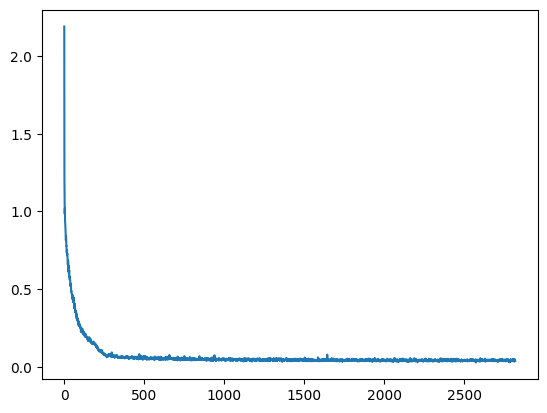

In [8]:
plt.plot(rectified_flow_1.loss_curve)
plt.show()

In [9]:
torch.save(rectified_flow_1, "./models/MNIST_newest.pth")

In [10]:
rectified_flow_1 = torch.load("./models/MNIST_newest.pth")

tensor([[[[-0.9929, -0.9954, -1.0026,  ..., -1.0024, -1.0011, -0.9928],
          [-0.9951, -0.9978, -1.0032,  ..., -1.0013, -1.0004, -0.9991],
          [-0.9935, -0.9980, -1.0044,  ..., -1.0019, -1.0020, -0.9960],
          ...,
          [-0.9999, -0.9972, -0.9999,  ..., -0.9991, -1.0012, -1.0068],
          [-1.0063, -1.0008, -0.9997,  ..., -1.0003, -0.9998, -1.0016],
          [-1.0049, -1.0036, -1.0030,  ..., -1.0055, -1.0058, -1.0027]]]],
       device='cuda:0')


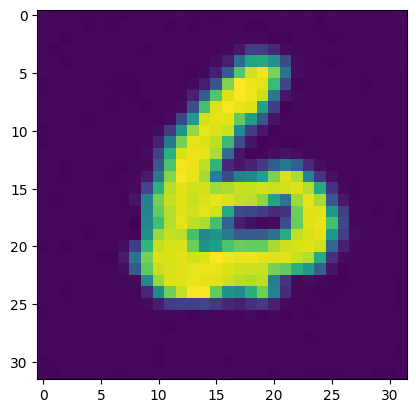

In [11]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(1,1,32,32).to(device) / 3

img = rectified_flow_1.sample_ode(img_init, 100)

print(img[-1])

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

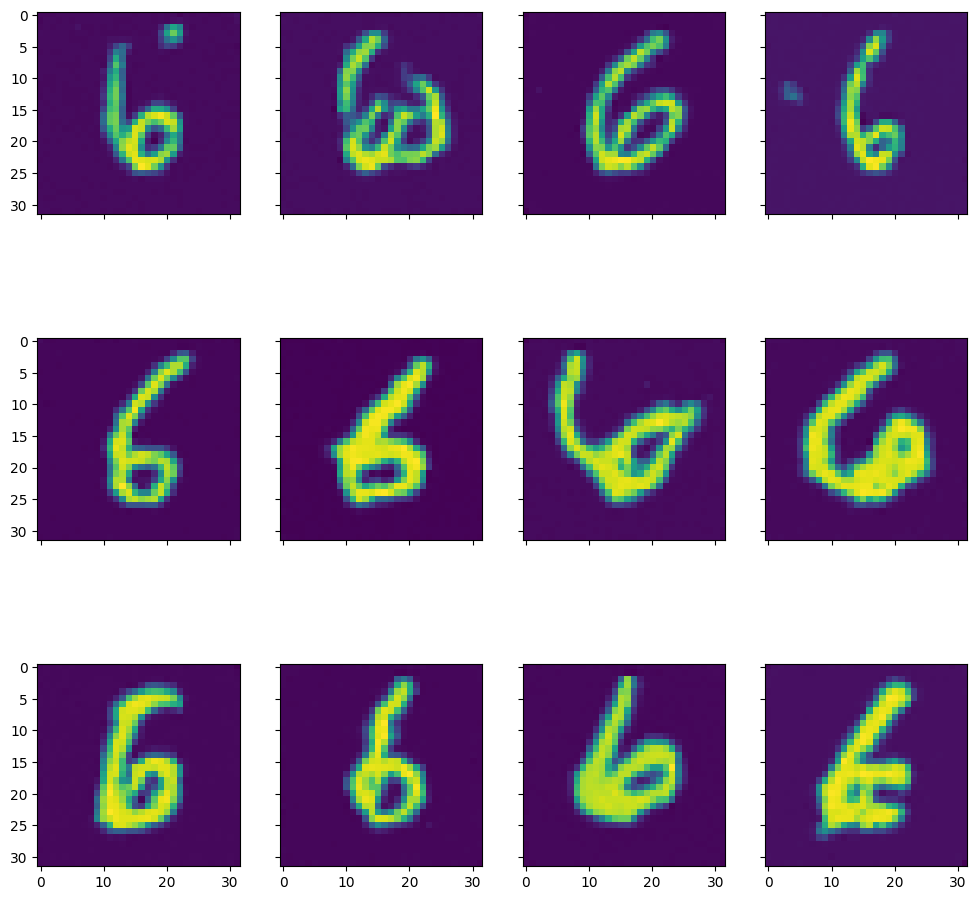

In [12]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

for row in range(rows):
    for column in range(columns):
        img_init = torch.randn(1,1,32,32).to(device) / 3

        img = rectified_flow_1.sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
        ax[row, column].imshow(img)

plt.show()